In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
sns.set_palette('muted', color_codes=True)

import itertools as it
from collections import Counter, defaultdict, deque

In [2]:
# ---------- Functional utils ---------- #
from toolz import pipe
from toolz.curried import *
max = curry(max)
min = curry(min)
call = lambda f: f()
@curry
def attr(name, obj):
    return getattr(obj, name)
@curry
def invoke(name, obj):
    return getattr(obj, name)()

lmap = curry(compose(list, map))
amap = curry(compose(np.array, lmap))

In [5]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='html5')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import colors
from matplotlib import pyplot as plt
cdef = ['#ffffff', '#111111', '#FC4754', '#4A74FF']
cmap = colors.ListedColormap(cdef)
bounds = np.arange(cmap.N + 1)
cnorm = colors.BoundaryNorm(bounds, cmap.N)

# Maze

In [3]:
from agents import *
from envs import *
from meta import *
agent = Agent()
base_env = GridWorld.random_maze(16)
base_env.render()

def heuristic(obs):
    row, col = obs
    g_row, g_col = base_env.goal
    return base_env.move_cost * (abs(row - g_row) + abs(col - g_col))

policy = MetaSearchPolicy()
env = MetaSearchEnv(base_env, policy.eval_node)
env.reset()
agent.register(env)
agent.register(policy)
trace = agent.run_episode()
print(trace['return'])

TypeError: __init__() got an unexpected keyword argument 'init_state'

In [18]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='html5')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


fig = plt.figure()


from matplotlib import colors
from matplotlib import pyplot as plt
cdef = ['#ffffff', '#111111', '#FC4754', '#4A74FF']
cmap = colors.ListedColormap(cdef)
bounds = np.arange(cmap.N + 1)
cnorm = colors.BoundaryNorm(bounds, cmap.N)

# env.reset()
env = surface_env
X = env.render(mode='array')

frontier = False
if frontier:
    im = plt.imshow(X, aspect='equal', cmap=cmap, norm=cnorm, animated=True)
    frames = policy.saved['frontier']
    def updatefig(h):
    #     r,c = h['state']
        X1 = X.copy()
        for (r,c) in h:
            X1[r,c] = 3
        im.set_array(X1)
        return im,
else:
    trace = env.surface_agent.ep_trace
    im = plt.imshow(X, aspect='equal', cmap=cmap, norm=cnorm, animated=True)
    frames = iter(trace['actions'])
    def updatefig(a):
        env.step(a)
        X = env.render(mode='array')
        im.set_array(X)
        return im,

anim = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, 
                        frames=frames, )
anim
# anim.save('a-star.gif', writer='imagemagick', fps=10)

GOAL IS (13, 3)


UnsupportedMode: <MetaSearchEnv instance> does not support rendering (requested mode: array)

In [22]:
def heuristic(env, obs):
    row, col = obs
    g_row, g_col = env.goal
    return env.move_cost * (abs(row - g_row) + abs(col - g_col))

from agents import *
from envs import GridWorld
agent = Agent()
env = GridWorld.random_maze(16)
env.reset()
env.render()

policy = Astar(heuristic)
agent.register(env)
agent.register(policy)
trace = agent.run_episode()
print(len(trace['actions']), trace['return'])

# Pain

In [6]:
def plot_line(env, trace, title=None):
    im = plt.imshow(env.rewards, aspect='equal', cmap='Reds_r')
#     txt = plt.text(0, 0, 'A', color='#4A74FF', weight='bold', size=24,
#                      verticalalignment='center', horizontalalignment='center')
    plt.scatter(*np.stack(trace['states']).T, c='w', edgecolors='b', linewidths=1)
    if title:
        plt.title(title)
    plt.show()

best_finished = Node(state=(8, 9), path=[1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2], reward=-21.847902187020356, done=True)


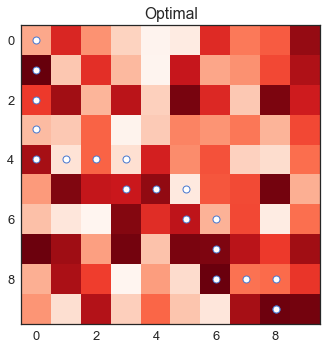

best_finished = Node(state=(8, 9), path=[1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2], reward=-21.847902187020356, done=True)


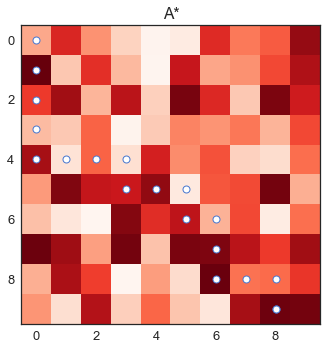

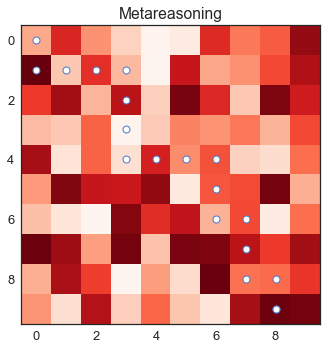

In [9]:
from agents import *
from envs import *
from meta import *
from policies import *

R = -np.random.random((10, 10)) - 1
base_env = GridWorld('pain', size=10, rewards=R)

def heuristic(env, obs):
    row, col = obs
    g_row, g_col = env.goal
    return - ((abs(row - g_row) + abs(col - g_col)))

agent = Agent()
astar = Astar(lambda env, s: 0)
agent.register(base_env)
agent.register(astar)
trace = agent.run_episode()
plot_line(base_env, trace, 'Optimal')

agent = Agent()
astar = Astar(heuristic)
agent.register(base_env)
agent.register(astar)
trace = agent.run_episode()
plot_line(base_env, trace, 'A*')

agent = Agent()
policy = MetaBestFirstSearchPolicy()
env = MetaBestFirstSearchEnv(base_env, policy.eval_node)
agent.register(env)
agent.register(policy)
agent.run_episode()
plot_line(base_env, env.surface_agent.ep_trace, 'Metareasoning')

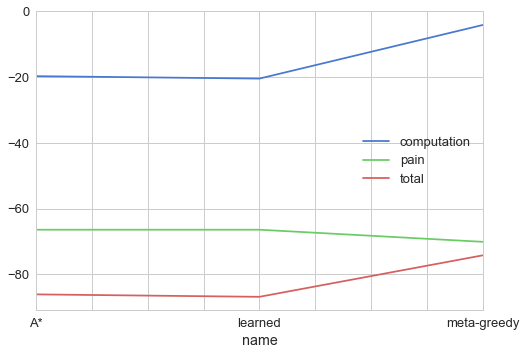

In [17]:
from agents import *
from envs import *
from meta import *

envs = []
def data(N=1):
    min_cost = -1
    extra_cost = -10
    mean_cost = min_cost + extra_cost / 2
    policies = {
        'A*': MetaBestFirstSearchPolicy([1, min_cost]),
        'meta-greedy': MetaBestFirstSearchPolicy([1, mean_cost]),
        'learned': MetaBestFirstSearchPolicy(None),
    }
    yield policies
    agent = Agent()
    for i in range(N):
        R = min_cost + extra_cost * np.random.random((10, 10))
        # R[-1] = 0
        base_env = GridWorld('pain', size=10, rewards=R)
        envs.append(base_env)
        for name, policy in policies.items():
            env = MetaBestFirstSearchEnv(base_env, policy.eval_node, expansion_cost=.2)
            agent.register(env)
            agent.register(policy)
            r = agent.run_episode()['rewards']
            yield {'env': i, 'name': name, 'computation': sum(r[:-1]),
                   'pain': r[-1], 'total': sum(r)}

D = data(10)
policies = next(D)
df = pd.DataFrame(D)
sns.set_style('whitegrid')
df.groupby('name')['computation', 'pain', 'total'].mean().plot()
sns.set_style('white')
plt.legend()


In [21]:
policies['learned'].saved['weights']

[array([[ 0.69 ],
        [ 0.614]], dtype=float32), array([[ 0.691],
        [ 0.613]], dtype=float32), array([[ 0.692],
        [ 0.612]], dtype=float32), array([[ 0.693],
        [ 0.611]], dtype=float32), array([[ 0.694],
        [ 0.61 ]], dtype=float32), array([[ 0.695],
        [ 0.609]], dtype=float32), array([[ 0.696],
        [ 0.608]], dtype=float32), array([[ 0.697],
        [ 0.607]], dtype=float32), array([[ 0.698],
        [ 0.606]], dtype=float32), array([[ 0.699],
        [ 0.605]], dtype=float32)]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


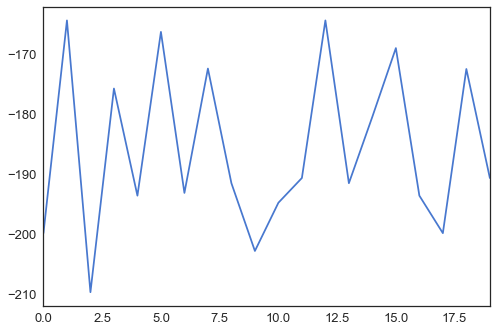

In [367]:
from agents import *
from envs import *
from meta import *

agent = Agent()
policy = MetaBestFirstSearchPolicy()
env = MetaBestFirstSearchEnv(base_env, policy.eval_node, 0)
agent.register(env)
agent.register(policy)
# trace = agent.run_many(50)
trace = agent.run_many(20)
df = pd.DataFrame(trace)
df['return'].plot()
# trace = agent.run_episode()

In [371]:
np.stack([w.flat for w in policy.saved['weights']])

array([[-0.629,  0.304],
       [-0.628,  0.303],
       [-0.627,  0.302],
       [-0.626,  0.301],
       [-0.625,  0.3  ],
       [-0.624,  0.299],
       [-0.623,  0.298],
       [-0.622,  0.297],
       [-0.621,  0.296],
       [-0.62 ,  0.295],
       [-0.619,  0.294],
       [-0.618,  0.293],
       [-0.617,  0.292],
       [-0.616,  0.291],
       [-0.615,  0.29 ],
       [-0.614,  0.289],
       [-0.613,  0.288],
       [-0.612,  0.287],
       [-0.611,  0.286],
       [-0.611,  0.285]], dtype=float32)

In [316]:
from models import BayesianRegression


In [323]:
X

array([[-0.989,  0.76 ,  0.77 ,  0.497, -0.486,  1.826, -0.538, -1.144,  1.616, -1.153],
       [-0.573, -1.471,  0.369, -2.317, -1.74 ,  0.08 ,  2.056, -0.762, -0.275, -1.649]])

In [327]:
X  @ beta

array([-1.082, -1.163,  0.963,  3.263, -3.969, -3.693, -1.08 ,  0.134, -2.038,  1.228])

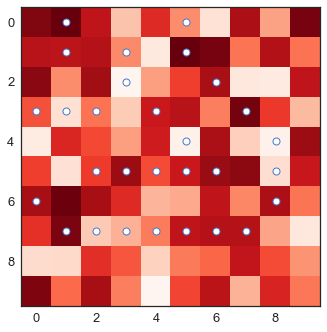

In [380]:
fig = plt.figure()

im = plt.imshow(env.env.rewards, aspect='equal', cmap='Reds_r')
frontier = True
if frontier:
    scatter = plt.scatter([], [], c='w', edgecolors='b', linewidths=1)
#     im = plt.imshow(env.env.rewards, aspect='equal', cmap='Reds_r')
#     env.env.render()
    frames = policy.saved['frontier'][:100]
    def updatefig(h):
        scatter.set_offsets(h)
        return scatter,
else:
    trace = env.surface_agent.ep_trace
    txt = plt.text(0, 0, 'A', color='#4A74FF', weight='bold', size=24,
                     verticalalignment='center', horizontalalignment='center')
    frames = iter(trace['states'][:100])
    def updatefig(s):
        txt.set_position(s)
#         env.step(a)
#         X = env.render(mode='array')
#         im.set_array(X)
        return txt,

anim = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, 
                        frames=frames, )
anim
# anim.save('a-star.gif', writer='imagemagick', fps=10)

In [157]:
env.env.rewards[:3, :3]

array([[-0.576, -0.232, -0.123],
       [-0.635, -0.257, -0.621],
       [-0.574, -0.547, -0.462]])

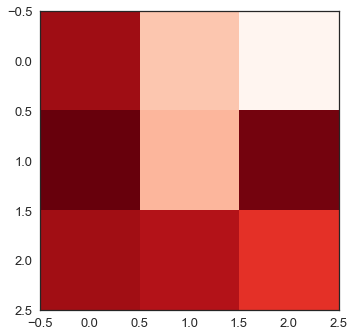

In [158]:
plt.imshow(env.env.rewards[:3, :3], cmap='Reds_r')

In [ ]:
env.reset()
env.render(mode='human')
for a in tr['actions']:
    time.sleep(1)
    env.step(a)
    env.render(mode='human')


In [ ]:
N_EP = 40
SIZE = 10
from agents import *
from envs import ForageWorld
env = ForageWorld(SIZE, 4, .05)
agent = Agent()
agent.register(env)
env.reset()
V = BayesianRegressionV()
agent.register(V)
agent.register(SearchPolicy(V, noise=0))
trace = agent.run_many(N_EP, max_steps=100)

In [ ]:
np.random.randn()

In [ ]:
from scipy.stats import norm

In [ ]:
def ret(n, sig):
    return sum(np.random.randn() * sig for _ in range(n))

d = [ret(2, 1) for _ in range(1000)]
sns.distplot(d)
norm.fit(d)
    

In [ ]:
softmax([1,1,2])

In [ ]:
x = np.random.rand(4)
theta = np.random.rand(4, 2)
x @ theta

In [ ]:
plt.plot(rolling_max(map(get('v'), agent.policy.node_history), 200))

In [ ]:
df = pd.DataFrame(trace)
df['return'].plot()

In [ ]:
sns.set_style('whitegrid')
w = V.model.w
idx = [0,1,2,3,4,5,6,7,8,9,10,len(w)-1]
w = w[idx]
var = V.model.sigma_w[idx]
# plt.bar(range(len(idx)), w)
plt.errorbar(range(len(idx)), w, var)
# plt.fill_between(range(len(idx)), w-var, w+var, alpha=0.4)
# plt.ylim(-2, 2)

In [ ]:
from utils import dict_product
from envs import ForageWorld
from agents import *

def rolling_max(seq, length):
    seq = iter(seq)
    best = next(seq)
    lst = np.zeros(length) - 1000
    lst[0] = best
    for i, x in enumerate(seq, start=1):
        best = max(x, best)
        lst[i] = best 
    for j in range(i, length):
        lst[j] = best
    return lst
    
        

def data(params, n=20):
    for i, pr in enumerate(params):
        print(pr)
        env = ForageWorld(**pr)
        agent = Agent()
        agent.register(env)
        V = FixedV([0, 1] + [0] * (pr['size'] ** 2))
        agent.register(V)
        agent.register(SearchPolicy(V, noise=0))
        rets = []
        for _ in range(n):
            agent.run_episode()
            nh = agent.policy.node_history
            rets.append(rolling_max(map(get('v'), nh), 2000))
        yield {**pr, 'ret': np.stack(rets).mean(0)}

params = {
    'size': [6,8,10,12],
    'n_berry': 5,
    'time_cost': 0.05,
}
df = pd.DataFrame(data(dict_product(params)))

In [ ]:
time_cost = np.arange(2000) * -0.001
colors = iter(sns.color_palette('deep'))
color = defaultdict(lambda: next(colors))
ls = {0.05: '-', 0.1: '--'}
for (nb, s, tc), dd in df.groupby(['n_berry', 'size', 'time_cost']):
    x = dd.ret.iloc[0] + time_cost
    plt.plot(x[:1000], c=color[s], ls=ls[tc])
plt.legend()

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image
sns.set_style('whitegrid')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

def get_states(path):
    env.reset()
    yield (SIZE // 2, SIZE //2)
    for a in path:
        s1, r, done, _ = env.step(a)
        yield env._state[:2]

def init():
    pathcol.set_offsets([[], []])
    return [pathcol]

def update(i, pathcol, nodes):
    data = np.array(list(get_states(nodes[i].path)))
    pathcol.set_offsets(data)
    return [pathcol]

fig = plt.figure()
ax = plt.axes(xlim=(-0.5, SIZE+.5), ylim=(-0.5, SIZE+.5))
plt.xticks(range(0,SIZE))
plt.yticks(range(0,SIZE))
ax.scatter(*np.array(list(env.berry_locs.keys())).T, 
           c='r', marker='x',  s=120)
pathcol = ax.scatter([], [], s=100)

nodes = agent.policy.node_history[200:300]
T = len(nodes)

anim = FuncAnimation(
    fig, update, init_func=init, fargs=(pathcol, nodes), interval=200, frames=T, 
    blit=True, repeat=True)

display_animation(anim)

In [ ]:
plot = plt.scatter([], [], s=100)
fig1 = plt.figure()
plt.axis('equal')
plt.xlim(0, SIZE)
plt.ylim(0, SIZE)

nodes = agent.policy.node_history
ani = FuncAnimation(fig1, plot_node, 20, fargs=(nodes, plot),      
                                   interval=100, blit=True)
display_animation(ani)

In [ ]:
df = pd.DataFrame(trace)
sns.factorplot('berries', 'return', data=df)
plt.axis('equal')
# plt.plot([0, 2], [0, 2], ls='--')

In [ ]:
# N_EP = 50
# trace = agent.run_many(N_EP, max_steps=100)
roll = 2

df = pd.DataFrame(trace)
cols = ['v0', 'vx', 'vy', 'vb'] 
# cols.extend(['vxy', 'vxb', 'vyb'])
tdf = pd.DataFrame(list(df.theta_v), columns=cols).clip(-10, 100)
df = df.join(tdf).drop('theta_v', axis=1)
# sns.factorplot('berries', 'return', data=df)
# df['return'].rolling(roll).mean().plot()
# sns.lmplot('i_episode', 'vb', data=df)
df[cols + ['return', 'berries']].rolling(roll).mean().plot()
plt.axhline(0, ls='--', c='gray')

In [ ]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features = 100, 5
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features)
y = X @ theta + 0.5 * np.random.randn(n_samples)
clf = SGDRegressor()
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)


In [ ]:
class LinearSGD(object):
    """Learns a linear approximation by SGD."""
    def __init__(self, shape, learn_rate=.1):
        self.shape = shape
        self.learn_rate = learn_rate
        self.theta = np.random.random(self.shape)

    def update(self, x, y):
        yhat = x @ self.theta
        error = y - yhat
        self.theta += self.learn_rate * np.outer(x, error)

    def predict(self, x):
        return x @ self.theta

mod = LinearSGD((n_features, 1), .1)
for i in range(len(X)):
    mod.update(X[i], y[i])

yhat = [mod.predict(x)[0] for x in X]
rms_error(y, yhat)

In [ ]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features, n_output = 10, 5, 2
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features, n_output)
y = X @ theta
# clf = SGDRegressor()
# clf.partial_fit(X, y)
y

In [ ]:
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)

In [ ]:
def bin(x):
    return pd.cut(x, 10).apply(lambda x: x.mid)

bdf = pd.DataFrame({
    'vb': bin(df.vb),
    'ep': bin(df.i_episode),
    'return': df['return']
})
sns.heatmap(bdf.pivot_table('return', 'vb', 'ep'))

In [ ]:
agent.depth = 2
agent.run_episode()

In [ ]:
V = agent.V.to_array().reshape(5, 5)
sns.heatmap(V)

In [ ]:
from agents import QLearningAgent
from envs import GridEnv

env = GridEnv(5, 5)
agent = QLearningAgent(env)
agent.Q.theta
# agent.Q.theta
# trace = agent.run_many(500)
agent.run_many(100)

In [ ]:
plt.plot(trace['return'])

In [ ]:
# agent.run_many(1000)
print(agent.V.theta)
# agent.V.theta = np.array([0, 100])
X = np.linspace(-1,1, 101)
plt.plot(X, lmap(agent.V, map(agent.phi, X)))